# Notebook for Creating Figures from OpenFOAM Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv

## Define Helper Files

In [2]:
def camera_settings(PYLON=False):
    """ Define settings for viewing the figures """
    if PYLON is True:
        camera = pv.Camera()
        camera.position = (15.9143, 3.83627, 28.3582)
        camera.focal_point = (15.9143, 3.83627, 13.75)
        camera.view_angle = 30
    else:
        camera = pv.Camera()
        camera.position = (15.9919, 3.10319, 67.1243)
        camera.focal_point = (15.9919, 3.10319, -5.08432e-08)
        camera.view_angle = 30
    
    return camera

In [3]:
def slice_center(mesh, NORMAL='z', ORIGIN=[0, 0, 0], translate=False, CONTOUR=False):
    """Slice mesh through center in normal direction, move to zero normal."""
    slice_mesh = mesh.slice(normal=NORMAL, origin=ORIGIN, contour=CONTOUR)
    if translate is not False:
        if NORMAL == 'z':
            slice_mesh.translate((0, 0, -slice_mesh.center[-1]), inplace=True)
        elif NORMAL == 'x':
            slice_mesh.translate((-slice.mesh.center[0], 0, 0), inplace=True)
        elif NORMAL == 'y':
            slice_mesh.translate((0, -slice.mesh.center[1], 0), inplace=True)
        else:
            print('ERROR: Normal not found - ', NORMAL)
            slice_mesh = None
    return slice_mesh

In [4]:
def read_mesh(nfile):
    """ Read the OpenFOAM solution, needs the file generated by paraFoam (e.g. *.OpenFOAM) """
    # Read the reference file created by openFOAM `parafoam`
    reader = pv.POpenFOAMReader(nfile)
    # set the active time 
    reader.set_active_time_value(reader.time_values[-1])
    reader.cell_to_point_creation = True
    # Define the mesh
    mesh = reader.read()
    # Define the internal mesh and boundaries
    internal = mesh["internalMesh"]
    boundaries = mesh["boundary"]
    
    return internal, boundaries

In [83]:
def sample_line(mesh, pointA, pointB, field=None):
    """ Sample fields across a line, marked by two points, within the mesh """
    # Sample across the mesh designated by inputed points
    line = mesh.sample_over_line(pointA,
                                 pointB,
                                 resolution=100,
                                 tolerance=0.2,
                                 )
    # Define the distance of this line
    distance = joe['Distance']
    
    # Check to see if a desired field to extract
    if field is not None:
        subset = line.get_array(field)
    else:
        subset = None
    
    if field is not None:
        return distance, subset
    else:
        return distance, line

In [59]:
def plot_field(ndir, 
               nfile,
               FIELD='U', 
               RANGE=[95, 145], 
               CONTOUR=True, 
               ORIGIN=[0, 0, 0], 
               NORMAL='z', 
               CMAP='bwr',
               SAVE=False,
               PYLON=False):
    """ 
    Create 2-D Figure of the OpenFOAM internal mesh for selected field. 
    Normal decides which plane to exclude from display.
    Origin moves where the slice is preformed.
    """
    # add extension to the input directory file to reference *.OpenFOAM files
    solution = ndir + nfile['filename'] + nfile['filename'][:-1] + '.OpenFoam'
    
    # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [C]"
            }
    
    # Read the Mesh
    internal, boundaries = read_mesh(solution)
    
    # Slice the Mesh
    if PYLON is True:
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=nfile['pylon'])
    else:
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=ORIGIN)
    
    # Contour the Mesh
    contours = p3_slice.contour(scalars=FIELD, isosurfaces=15, rng=RANGE)
    
    # Set a custom position and size
    sargs = dict(height=0.10, 
                 vertical=False, 
                 position_x=0.2, 
                 position_y=0.05, 
                 fmt="%.0f", 
                 color='black', 
                 n_labels=6, 
                 title=LABEL[FIELD])
    
    # Create the plotter
    pt = pv.Plotter()
    # Add the slice mesh
    pt.add_mesh(p3_slice, 
                scalars=FIELD, 
                preference='point', 
                cmap=CMAP, 
                clim=RANGE,
                scalar_bar_args=sargs)
    
    # Add the contours
    pt.add_mesh(contours, 
                color='white', 
                preference='cell', 
                line_width=1)
    
    # Add a ruler
    if PYLON is True:
        pt.add_ruler(pointa=[10, -0.35, 0.0],
                     pointb=[20, -0.35, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
    else:
        pt.add_ruler(pointa=[-5, -5, 0.0],
                     pointb=[35, -5, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
   
    # Add a title
    pt.add_title(nfile['filename'][:-1], 
                 font='courier', 
                 color='k', 
                 font_size=10
                )
    
    # Define the camera view
    if PYLON is True:
        pt.camera = camera_settings(PYLON=True)
    else:
        pt.camera = camera_settings()
    
    # Save the figure
    if SAVE is True:
        # Define a figure title
        nout = nfile['filename'][:-1] + '_' + str(FIELD) + '.svg'
        # Save the figure
        pt.save_graphic(nout, raster=True)
        
    # Make two points to construct the line between
    A = [13, nfile['pylon'][1], nfile['pylon'][2]]
    B = [13.922, nfile['pylon'][1], nfile['pylon'][2]]

    # Preview how this line intersects this mesh
    line = pv.Line(A, B)
    pt.add_mesh(line, color="white", line_width=10)
        
    # Display the figure
    pt.show()
    
    # Free up some memory
    del internal, p3_slice, contours, boundaries, pt

In [6]:
def plot_line(ndir, 
              nfiles,
              config='120',
              FIELD='U', 
              ORIGIN=[0, 0, 0], 
              NORMAL='z', 
              SAVE=False
             ):
    """ 
    Create line plot of the internal mesh as a distance from the pylon for selected field. 
    Normal decides which plane to exclude from display.
    Origin moves where the slice is preformed.
    config file marks which set of solutions we are comparing
    """
    # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [C]"
            }
    
    for case in nfiles:
        if config in case:
            # add extension to the input directory file to reference *.OpenFOAM files
            solution = ndir + nfiles[case]['filename'] + nfiles[case]['filename'][:-1] + '.OpenFoam'
    
            # Read the Mesh
            internal, boundaries = read_mesh(solution)
    
            # Slice the Mesh
            p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=nfile['pylon'])
            
            mesh.plot_over_line(a,
                    b,
                    resolution=10000,
                    title="PMS Canister - Freestream Velocity = 120[m/s]",
                    ylabel="Velocity [m/s]",
                    figsize=(10, 5),
                    )

## Define the Directory, Case Structure, Fields and Pylon Locations

In [30]:
# Define the directory hosting the solution directories
solution_dir = "/Users/jrobrien/Dissertation/data/solutions/"
# Define available solution directories
case_dir = {'navy_120' : {'filename' : 'NASA_navyPylon_v2_tas120_aoa0_900T33/',
                          #'pylon' : [0, 2.74, 13.75]
                          'pylon' : [0, 2.75, 13.75]
                         },
            'extend_120' : {'filename' : 'NASA_extendedPylon_v2_tas120_aoa0_900T33/',
                            'pylon' : [0, 2.725, 13.7]
                           },
            'no_120' : {'filename' : 'NASA_noPylons_v2_tas120_aoa0_900T33/',
                        'pylon' : [0, 2.75, 13.7]
                       }
           }

In [8]:
scalar_field = {'U' : {'range' : [95, 145]},
                'T' : {'range' : [295, 318]},
                'p' : {'range' : [89000, 91000]}
               }

## Process the OpenFOAM Solutions

In [72]:
# Attempt at Processing this way
for case in case_dir:
    if case == 'extend_120':
        print(case_dir[case])
        #plot_field(solution_dir, case_dir[case], FIELD='p', RANGE=[89000, 91000], SAVE=True, PYLON=True)
        plot_field(solution_dir, case_dir[case], SAVE=True, FIELD='p', RANGE=[89000, 91000], PYLON=True)

{'filename': 'NASA_extendedPylon_v2_tas120_aoa0_900T33/', 'pylon': [0, 2.725, 13.7]}


Widget(value="<iframe src='http://localhost:56547/index.html?ui=P_0x169204370_11&reconnect=auto' style='width:…

In [10]:
for case in case_dir:
    if 'extend_120' in case:
            solution = solution_dir + case_dir[case]['filename'] + case_dir[case]['filename'][:-1] + '.OpenFoam'
    
            # Read the Mesh
            internal, boundaries = read_mesh(solution)
    
            # Slice the Mesh
            p3_slice = slice_center(internal, NORMAL='z', ORIGIN=case_dir[case]['pylon'])
            
            contours = p3_slice.contour(isosurfaces=np.arange(30, 160, 5))

In [11]:
p3_slice

PolyData (0x2ef6df580)
  N Cells:    43051
  N Points:   46904
  N Strips:   0
  X Bounds:   -1.500e+02, 5.000e+01
  Y Bounds:   -1.000e+02, 1.000e+02
  Z Bounds:   1.370e+01, 1.370e+01
  N Arrays:   20

[0, 2.725, 13.7]


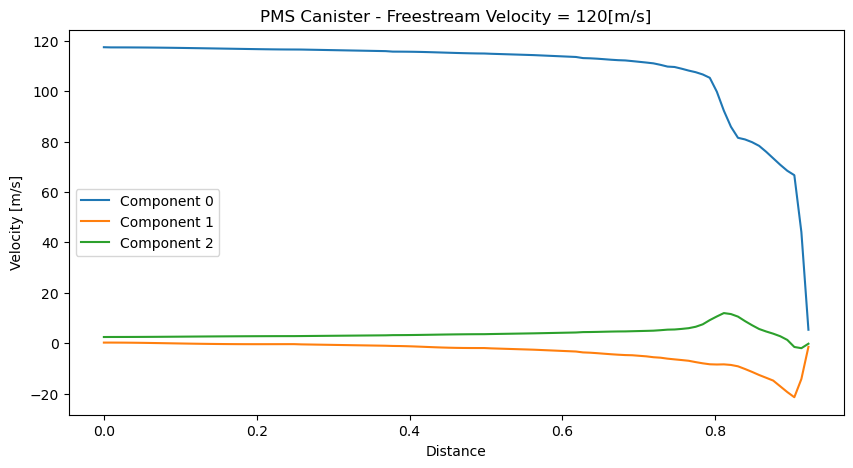

In [65]:
#A = [0, 0, 0]
A = [13.0, case_dir['extend_120']['pylon'][1], case_dir['extend_120']['pylon'][2]]
B = [13.922, case_dir['extend_120']['pylon'][1], case_dir['extend_120']['pylon'][2]]
print(case_dir['extend_120']['pylon'])
joe = p3_slice.plot_over_line(A,
                              B,
                              resolution=100,
                              scalars='U',
                              tolerance=0.2,
                              title="PMS Canister - Freestream Velocity = 120[m/s]",
                              ylabel="Velocity [m/s]",
                              figsize=(10, 5),
                              )

In [13]:
line_streamlines = p3_slice.streamlines('U',
                                    pointa=A,
                                    pointb=B,
                                    n_points=50,
                                    max_time=1000.0,
                                    compute_vorticity=False,  # vorticity already exists in dataset
                                   )

In [14]:
Umagpoint = np.sqrt((p3_slice.point_data['U'][:, 0]**2.0) + (p3_slice.point_data['U'][:, 1]**2.0) + (p3_slice.point_data['U'][:, 2]**2.0))

In [15]:
p3_slice.point_data['U-mag'] = Umagpoint

In [17]:
p3_slice

PolyData (0x2ef6df580)
  N Cells:    43051
  N Points:   46904
  N Strips:   0
  X Bounds:   -1.500e+02, 5.000e+01
  Y Bounds:   -1.000e+02, 1.000e+02
  Z Bounds:   1.370e+01, 1.370e+01
  N Arrays:   21

In [66]:
p3_slice.sample_over_line?

Signature:
p3_slice.sample_over_line(
    pointa,
    pointb,
    resolution=None,
    tolerance=None,
    progress_bar=False,
)
Docstring:
Sample a dataset onto a line.

Parameters
----------
pointa : sequence[float]
    Location in ``[x, y, z]``.

pointb : sequence[float]
    Location in ``[x, y, z]``.

resolution : int, optional
    Number of pieces to divide line into. Defaults to number of cells
    in the input mesh. Must be a positive integer.

tolerance : float, optional
    Tolerance used to compute whether a point in the source is in a
    cell of the input.  If not given, tolerance is automatically generated.

progress_bar : bool, default: False
    Display a progress bar to indicate progress.

Returns
-------
pyvista.PolyData
    Line object with sampled data from dataset.

Examples
--------
Sample over a plane that is interpolating a point cloud.

>>> import pyvista
>>> import numpy as np
>>> np.random.seed(12)
>>> point_cloud = np.random.random((5, 3))
>>> point_cloud[:, 

In [77]:
joe = p3_slice.sample_over_line(A,
                                B,
                                resolution=100,
                                tolerance=0.2,
                                )
joe_vel = joe.get_array('U')
distance = joe['Distance']

In [81]:
joe_vel.shape

(101, 3)

In [80]:
distance.shape

(101,)

In [84]:
A = [13.0, case_dir['extend_120']['pylon'][1], case_dir['extend_120']['pylon'][2]]
B = [13.922, case_dir['extend_120']['pylon'][1], case_dir['extend_120']['pylon'][2]]
disx, field = sample_line(p3_slice, A, B)

In [95]:
field.point_data['U'].shape

(101, 3)

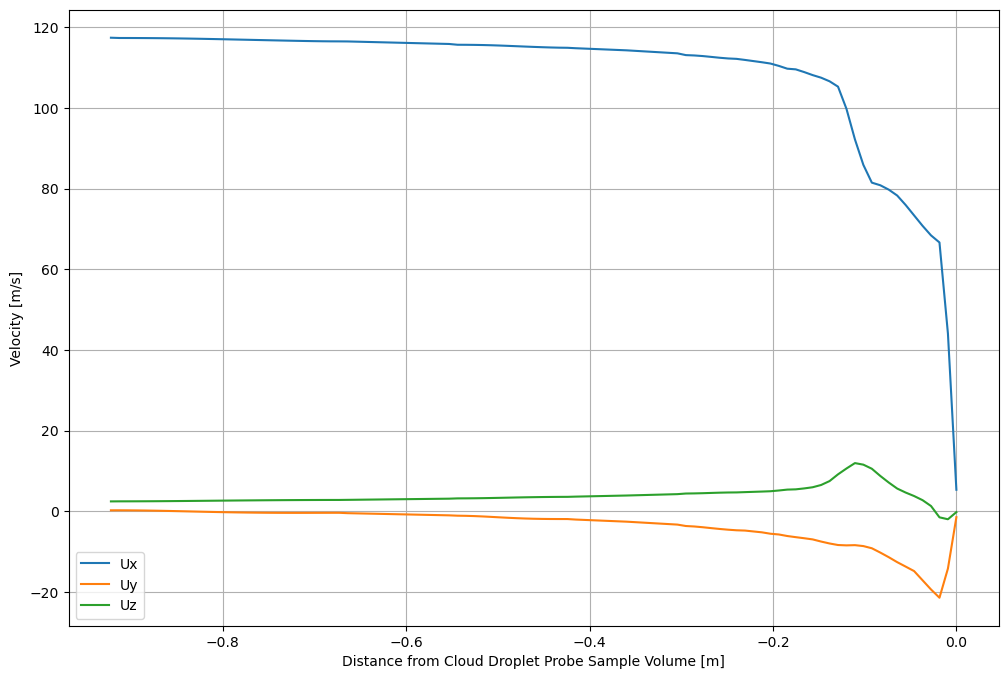

In [99]:
fig, axarr = plt.subplots(1, 1, figsize=[12, 8])
axarr.plot(disx-.922, field.point_data['U'][:, 0], label='Ux')
axarr.plot(disx-.922, field.point_data['U'][:, 1], label='Uy')
axarr.plot(disx-.922, field.point_data['U'][:, 2], label='Uz')
axarr.set_xlabel('Distance from Cloud Droplet Probe Sample Volume [m]')
axarr.set_ylabel('Velocity [m/s]')
axarr.grid(True)
plt.legend(loc='lower left')